In [21]:
%load_ext autoreload

%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import problem
import jax.numpy as jnp
import jax.scipy as jsp
import jax
import matplotlib.pyplot as plt
import yaml



#from problem import *

In [23]:
with open('config_basic.yml', 'r') as file:
        c = yaml.safe_load(file)

# Create spatial discretisation 
lat_first = c['spatial_discretisation']['lat_first']
lat_final = c['spatial_discretisation']['lat_final']
lat_n     = c['spatial_discretisation']['lat_n']
lng_first = c['spatial_discretisation']['lng_first']
lng_final = c['spatial_discretisation']['lng_final']
lng_n     = c['spatial_discretisation']['lng_n']

lat,lng = jnp.mgrid[lat_first:lat_final:lat_n*1j,
                    lng_first:lng_final:lng_n*1j]

# Test boundary aware functional equations

In [305]:
DTHETA, DLAMBDA = 1,1

class BoundaryAware():

    def __init__(self, state, neighbours):
        self.state = state
        self.nbs = neighbours

    def laplacian(self, y):
        
        return self.divergence(self.gradient(y)) +  y*(1-self.state)
        
        '''


        yb = y*self.state

        y_i_next = jnp.roll(yb, shift=1, axis=-2)
        y_i_prev = jnp.roll(yb, shift=-1,axis=-2)
        y_j_next = jnp.roll(yb, shift=1 ,axis=-1)
        y_j_prev = jnp.roll(yb, shift=-1,axis=-1)
        return  y*(1-self.state) + self.state*(y_j_next #
                                            + y_i_next
                                            - self.nbs * yb 
                                            + y_j_prev 
                                            + y_i_prev) / (DTHETA*DLAMBDA)'''
    def ptheta(self, y):
        y_i_next = jnp.roll(y, shift=1, axis=-2)
        y_i_prev = jnp.roll(y, shift=-1,axis=-2)

        f_i_next = jnp.roll(self.state, shift=1, axis=-2)
        f_i_prev = jnp.roll(self.state, shift=-1,axis=-2)

        return self.state * ( # there is only a valid derivative in fluid cells
                 f_i_next * f_i_prev     * (y_i_next - y_i_prev) / 2  # case where both neighbours are fluid
               + f_i_next * (1-f_i_prev) * (y_i_next - y)             # case where only the next neighbour is fluid
               + (1-f_i_next) * f_i_prev * (y - y_i_prev)             # case where only the previous neighbour is fluid
            )/DTHETA                                        # when neither neighbour is fluid, the previous two cases cancel out
             
    def plambda(self, y): 
        y_j_next = jnp.roll(y, shift=1, axis=-1)
        y_j_prev = jnp.roll(y, shift=-1,axis=-1)

        f_j_next = jnp.roll(self.state, shift=1, axis=-1)
        f_j_prev = jnp.roll(self.state, shift=-1,axis=-1)

        return self.state * (  # there is only a valid derivative in fluid cells
                 f_j_next * f_j_prev     * (y_j_next - y_j_prev) / 2  # case where both neighbours are fluid
               + f_j_next * (1-f_j_prev) * (y_j_next - y)             # case where only the next neighbour is fluid
               + (1-f_j_next) * f_j_prev * (y - y_j_prev)             # case where only the previous neighbour is fluid
            )/DTHETA                                        # when neither neighbour is fluid, the previous two cases cancel out

    def gradient(self, y):
        return jnp.array( (self.ptheta(y), self.plambda(y)))
    
    def divergence(self, y):
        y_i_next = jnp.roll(y[0], shift=1, axis=-2)
        y_i_prev = jnp.roll(y[0], shift=-1,axis=-2)
        y_j_next = jnp.roll(y[1], shift=1 ,axis=-1)
        y_j_prev = jnp.roll(y[1], shift=-1,axis=-1)
        return (y_i_next - y_i_prev + y_j_next - y_j_prev) #*self.state

In [189]:
def neighbours(state):
    s_i_next = jnp.roll(state, shift=1, axis=-2)
    s_i_prev = jnp.roll(state, shift=-1,axis=-2)
    s_j_next = jnp.roll(state, shift=1 ,axis=-1)
    s_j_prev = jnp.roll(state, shift=-1,axis=-1)

    return s_i_next + s_i_prev + s_j_next + s_j_prev

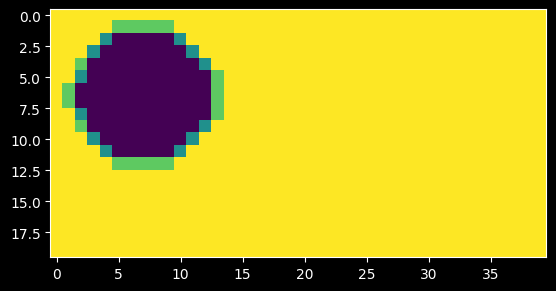

In [306]:
v = jnp.zeros((2, lat.shape[0], lat.shape[1]))
v = v.at[1].set( -1 * ((jnp.square(lat+0.5) + jnp.square(lng+0.5))<1) )

state = 1 - 1 * ((jnp.square(lat+0.5) + jnp.square(lng+2))<0.7)
state_neighbours = neighbours(state)*state

v *= state

plt.imshow(state_neighbours)
ba = BoundaryAware(state, state_neighbours)

Text(0.5, 1.0, 'purple solid, yellow fluid')

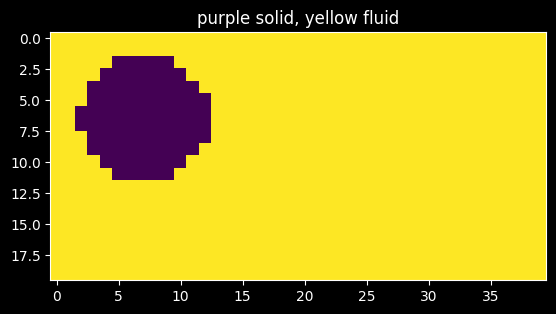

In [293]:
plt.imshow(state)
plt.title('purple solid, yellow fluid')

Text(0.5, 1.0, ' horizontal derivative of horizontal velocity')

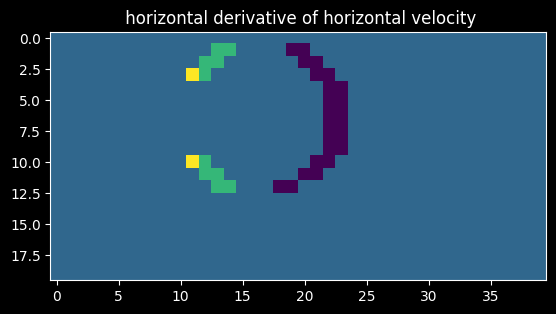

In [307]:
plt.imshow(ba.plambda(v[1]))
plt.title(' horizontal derivative of horizontal velocity')

Text(0.5, 1.0, 'laplacian of horizontal velocity')

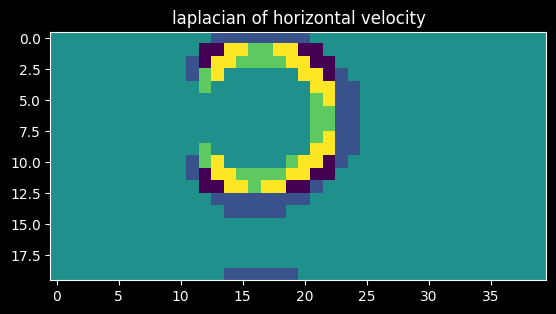

In [295]:
plt.imshow(ba.laplacian(v[1]))
plt.title('laplacian of horizontal velocity')

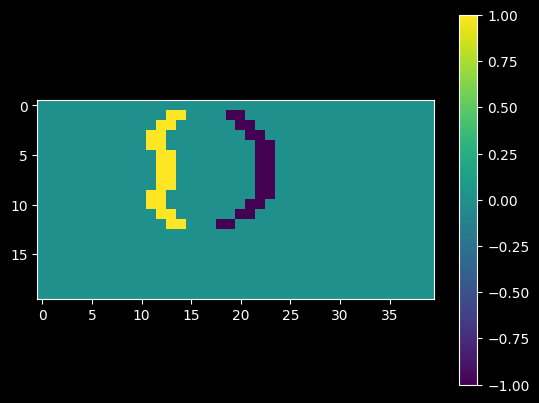

In [296]:
plt.imshow(ba.divergence(v) )
plt.colorbar()

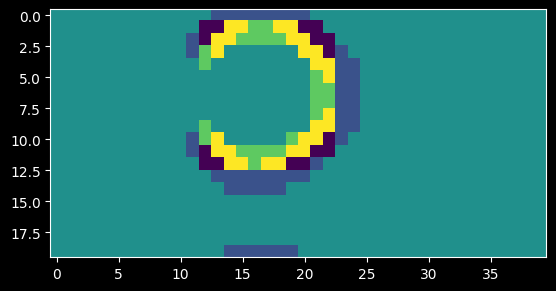

In [281]:
plt.imshow( ba.divergence( ba.gradient(v[1])))

# eval  stuff

In [234]:
def my_laplacian(x):
    x =x.reshape((20,40))
    thing = ba.laplacian(x)
    return thing.flatten()

##compute the jacobi matrix
jacobi = jax.jacobian(my_laplacian)

In [51]:
resuling_matrix = jacobi(jnp.ones(20*40))
resuling_matrix2 = jacobi(jnp.zeros(20*40))

In [59]:
((resuling_matrix - resuling_matrix.T) == 0).all()

Array(True, dtype=bool)

In [84]:
inverse_matrix = jnp.linalg.inv(resuling_matrix)

In [87]:
answer_eigy = jnp.linalg.eigh(resuling_matrix)

In [135]:
resuling_matrix.sum(axis = 0)

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [91]:
answer_eigy[1].shape

(800, 800)

In [99]:
(answer_eigy[1] @ jnp.diag(answer_eigy[0]) @ answer_eigy[1].T- resuling_matrix).std()

Array(6.0496157e-05, dtype=float32)

In [174]:
(answer_eigy[1] @ jnp.diag( answer_eigy[0]) @ answer_eigy[1].T)

Array([[-4.00013208e+00,  1.00010943e+00, -1.01493446e-04, ...,
        -1.27945867e-04,  1.39756739e-05,  3.35802033e-05],
       [ 1.00014305e+00, -4.00000095e+00,  1.00005317e+00, ...,
        -3.09912466e-05,  7.73636566e-05, -2.85095575e-05],
       [-9.58103483e-05,  9.99972999e-01, -3.99999809e+00, ...,
        -5.28532873e-05, -4.47291859e-05, -5.61240122e-05],
       ...,
       [-9.92643763e-05, -3.27095440e-05,  7.81553026e-05, ...,
        -4.00015259e+00,  1.00006092e+00,  5.45894000e-06],
       [-3.80794845e-05,  4.34930917e-06, -1.56673064e-04, ...,
         1.00004148e+00, -3.99989915e+00,  9.99959767e-01],
       [-2.73999158e-05,  4.14290116e-06, -5.18708657e-05, ...,
         6.33941163e-05,  9.99972403e-01, -4.00013590e+00]],      dtype=float32)

In [182]:
((resuling_matrix @ answer_eigy[1] ) / answer_eigy[0] - answer_eigy[1]).std()

Array(0.00125167, dtype=float32)

In [157]:
jnp.diag(answer_eigy[0])

Array([[-7.9912043,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       , -7.9646378,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       , -7.933261 , ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [ 0.       ,  0.       ,  0.       , ...,  1.0000024,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  1.0000026,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         1.0000033]], dtype=float32)

In [112]:
answer_eigy[1]

Array([[ 2.1869002e-02, -4.0640213e-02,  5.5453561e-02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-1.7990138e-02,  3.4082368e-02, -5.3948246e-02, ...,
        -2.3868074e-08,  1.6943527e-08,  9.8266199e-08],
       [ 1.4324356e-02, -2.7085230e-02,  5.0247490e-02, ...,
        -6.1885874e-10, -5.1301843e-09,  9.8928183e-08],
       ...,
       [ 3.4116361e-02, -5.5132076e-02,  4.8469923e-02, ...,
         9.3132257e-10,  8.3819032e-09, -3.8999133e-08],
       [-3.0422349e-02,  5.2335232e-02, -5.5392757e-02, ...,
        -1.0244548e-08, -1.8626451e-08,  3.9115548e-08],
       [ 2.6652619e-02, -4.8123468e-02,  5.9892938e-02, ...,
         3.7252903e-08,  1.6822014e-08, -1.5483238e-08]], dtype=float32)

In [153]:
answer_eigy[0][714]

Array(-0.0187469, dtype=float32)

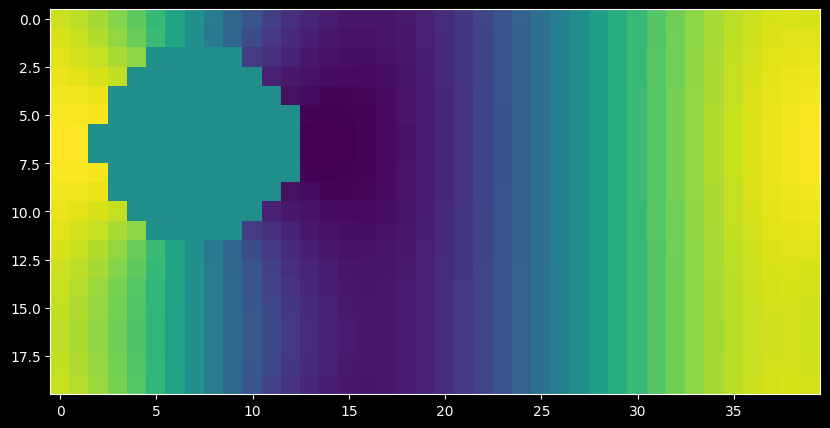

In [141]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.imshow( answer_eigy[1][:,714].reshape(20,40) )

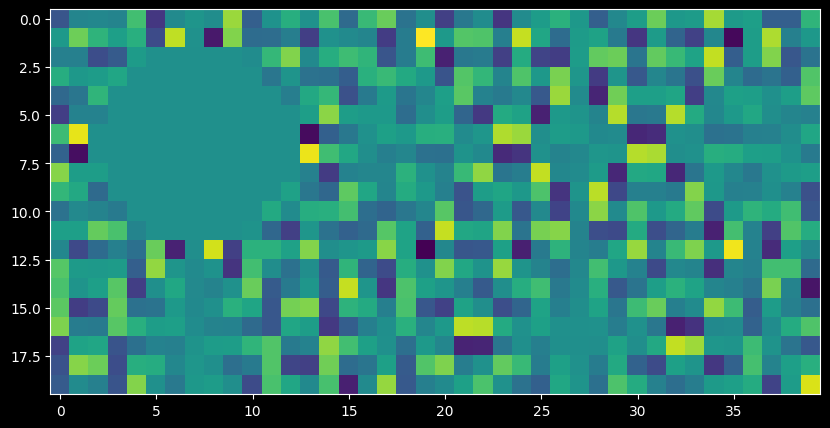

In [143]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.imshow( answer_eigy[1][:,400].reshape(20,40) )

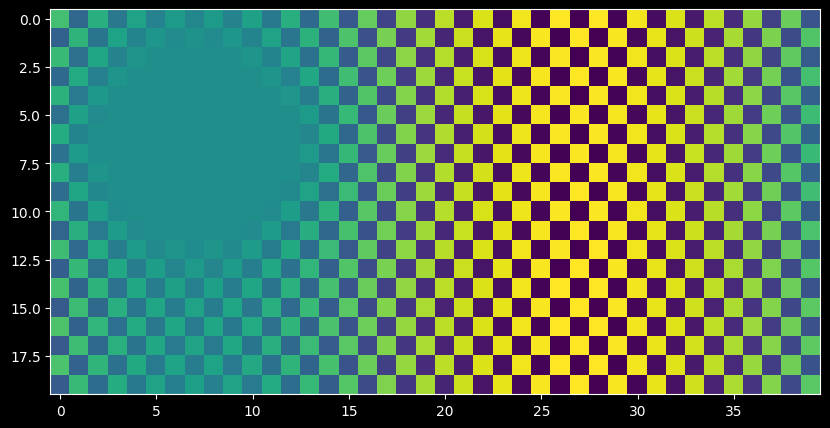

In [142]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.imshow( answer_eigy[1][:,0].reshape(20,40) )

In [102]:
jnp.sum(jnp.log( jnp.abs(answer_eigy[0])) )

Array(806.6772, dtype=float32)

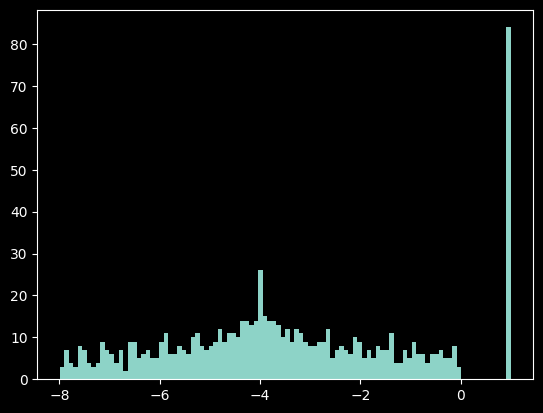

In [106]:
O = plt.hist(answer_eigy[0], bins = 100)

In [94]:
resuling_matrix

Array([[-4.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1., -4.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1., -4., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -4.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1., -4.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1., -4.]], dtype=float32)

In [78]:
resuling_matrix

Array([[-4.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1., -4.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1., -4., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -4.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1., -4.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1., -4.]], dtype=float32)

In [80]:
inverse_matrix @ resuling_matrix

Array([[ 8., -2.,  0., ...,  0.,  0.,  0.],
       [-2.,  8., -2., ...,  0.,  0.,  0.],
       [ 0., -2.,  8., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  8., -2.,  0.],
       [ 0.,  0.,  0., ..., -2.,  8., -2.],
       [ 0.,  0.,  0., ...,  0., -2.,  8.]], dtype=float32)

In [95]:
jnp.unique(jnp.array(resuling_matrix, dtype=jnp.int32), return_counts=True)

(Array([-4, -3, -2,  0,  1], dtype=int32),
 Array([   686,     18,     12, 636378,   2906], dtype=int32))

Array([-4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4,
       -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4,
       -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -3, -3, -3, -3, -3, -4,
       -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4,
       -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -2,
        1,  1,  1,  1,  1, -2, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4,
       -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4,
       -4, -4, -4, -4, -2,  1,  1,  1,  1,  1,  1,  1, -2, -4, -4, -4, -4,
       -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4,
       -4, -4, -4, -4, -4, -4, -4, -4, -4, -3,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -2, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4,
       -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -2,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -3, -4, -4, -4, -4, -4, -4, -4,
       -4, -4, -4, -4, -4

In [46]:
v[1].shape

(20, 40)

(20, 40)


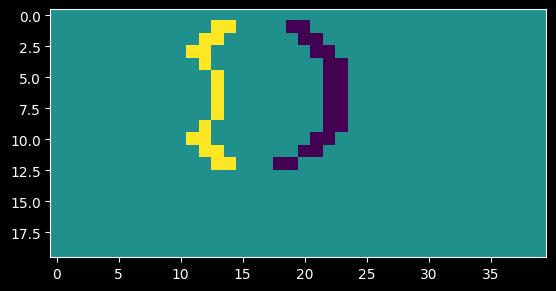

In [235]:
res = ba.divergence(v)
print(res.shape)

plt.imshow(ba.divergence(v))

# test divfree projection with boundary condidtions

In [336]:
#from problem import *



def project_divergencefree2(v, q_guess=None, state=None, fluid_neighbours=None, cg_runs = 2):

    ba = BoundaryAware(state, fluid_neighbours)

    q, _ = jsp.sparse.linalg.cg(
            ba.laplacian,
            -ba.divergence(v), 
            x0=q_guess)

    v_f = (v + ba.gradient(state*q))
    # Repeats as conjugate gradient descent does not necessarily converge to correct solution after 1 run
    for i in range(cg_runs):
        # q is the exact "pressure" needed to maintain densities
        qi, _ = jsp.sparse.linalg.cg(
            ba.laplacian,
            -ba.divergence(v_f), 
            maxiter= 1000)
        #q_total += q
        v_f += ba.gradient(qi)

    return v_f, q
    #return  q
    #return v + gradient(q)


In [309]:
# Initial conditions

v = jnp.zeros((2, lat.shape[0], lat.shape[1]))
v = v.at[1].set( -1 * ((jnp.square(lat+0.5) + jnp.square(lng+0.5))<1) )


state = 1 - 1 * ((jnp.square(lat+0.5) + jnp.square(lng+2))<0.7)
v*=state

fluid_neighbours = neighbours(state)

ba = BoundaryAware(state, fluid_neighbours)


Text(0.5, 1.0, 'blurred horizontal v')

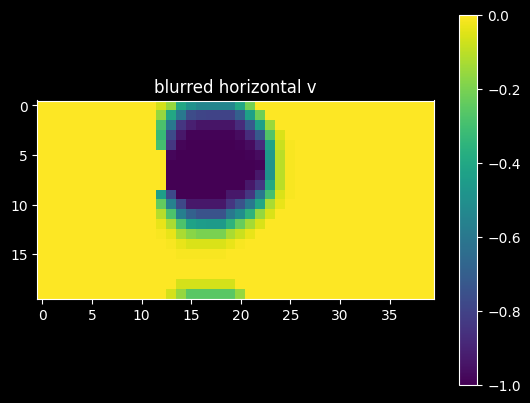

In [312]:
def blur(arr):
    return (jnp.roll(arr,  1, axis=-2)
          + jnp.roll(arr, -1, axis=-2)
          + jnp.roll(arr,  1, axis=-1)
          + jnp.roll(arr, -1, axis=-2)
          + arr) / (fluid_neighbours + 1 + 1-state) *state

v = blur(v)
#v = v.at[:,state==0].set(0)
plt.imshow(v[1])
plt.colorbar()
plt.title('blurred horizontal v')

Text(0.5, 1.0, 'divergence of v')

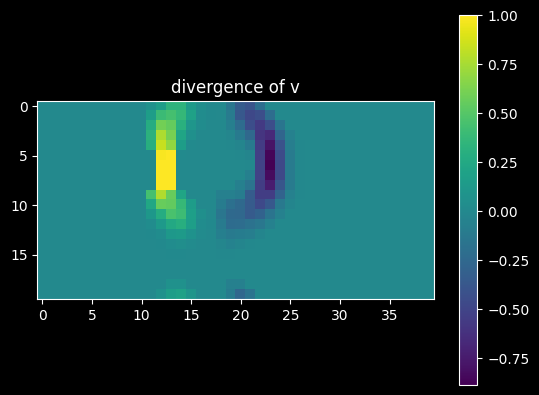

In [313]:
plt.imshow(ba.divergence(v))
plt.colorbar()
plt.title('divergence of v')

In [314]:
print(jnp.sum(ba.divergence(v)))
print(jnp.sum(problem.divergence(v)))

0.0
0.0


-0.45968276 0.38548413


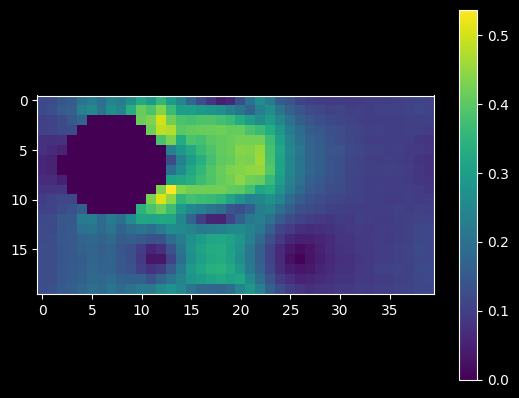

In [339]:
def normv(v): return jnp.sqrt(jnp.square(v[0]) + jnp.square(v[1]))

v_f, q1 = project_divergencefree2(v, state=state, fluid_neighbours = fluid_neighbours, cg_runs = 3)

print(jnp.amin(v_f), jnp.amax(v_f))

plt.imshow((normv(v_f)))
plt.colorbar()

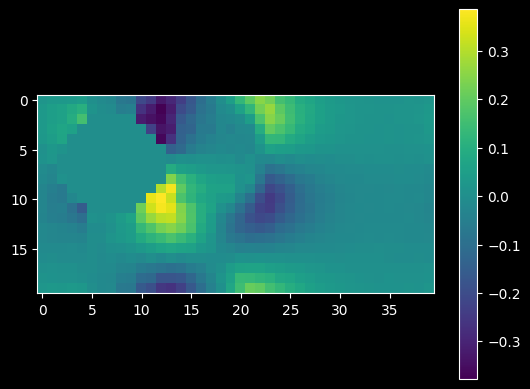

In [342]:
plt.imshow(v_f[0])
plt.colorbar()

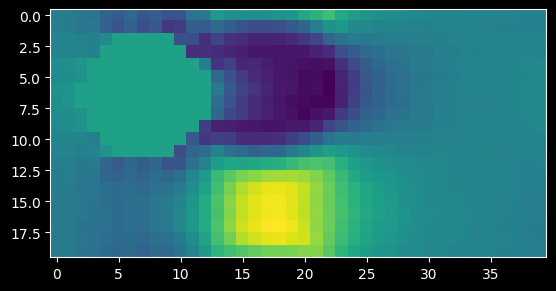

In [330]:
plt.imshow(v_f[1])

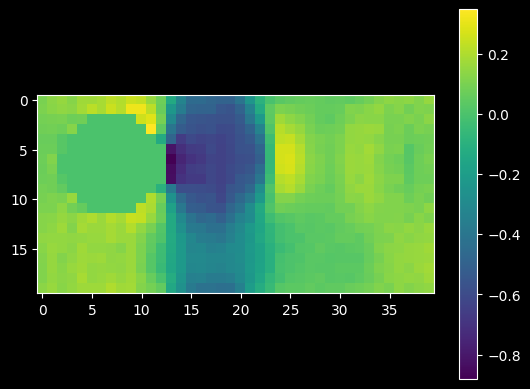

In [343]:
plt.imshow(-ba.plambda(q1))
plt.colorbar()

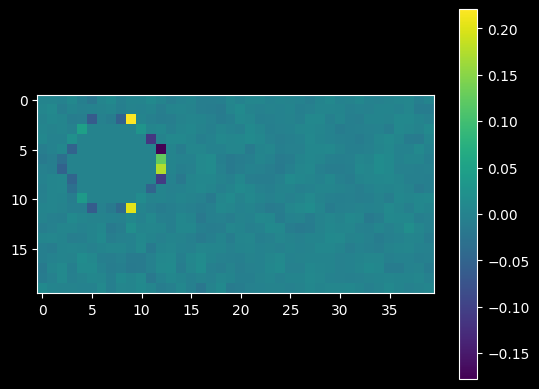

In [344]:
plt.imshow(ba.divergence(v_f))
plt.colorbar()

# test conjugate gradient on underdetermined system

In [152]:
A  = jnp.eye(5)
A  = A.at[3:5,3:5].set(0)
print(A)

b = jnp.ones((5,1))
print(b)

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]]


# bathymetry

In [38]:
import numpy as np

In [39]:
# Assuming `data` is your N-dimensional numpy array
data = np.random.rand(10, 20, 30)  # Example: 3D array
print('data created')

def plot_slice(x=0):
    plt.imshow(data[:, :, x], interpolation='nearest')
    plt.show()

interact(plot_slice, x=IntSlider(min=0, max=data.shape[2]-1, step=1, value=0))

data created


NameError: name 'interact' is not defined

opening path  /mnt/c/Users/spenc/OneDrive/Documents/GitHub/THCsim/resources/map/gebco_08_rev_bath_3600x1800_color.jpg
/mnt/c/Users/spenc/OneDrive/Documents/GitHub/THCsim/resources/map/gebco_08_rev_bath_3600x1800_color.jpg
(1800, 3600, 3)


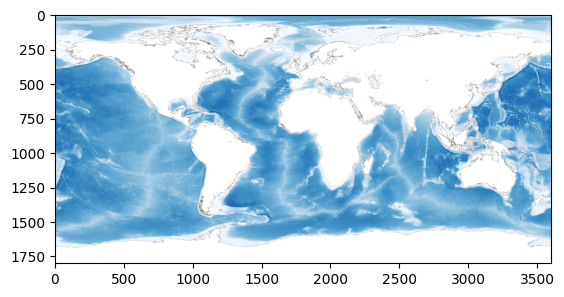

In [ ]:
import cv2
import numpy as np
import os

def get_map_path(config):

    if config["map"]["mask_image_path_relative"]:
        print('opening path ', os.path.join( os.getcwd(), config["map"]["mask_image_path"] ))
        print(os.path.join( os.getcwd(), config["map"]["mask_image_path"] ))
        return os.path.join( os.getcwd(), config["map"]["mask_image_path"] )
    else:
        return config["map"]["mask_image_path"]


def load_np(config):

    image_np = cv2.imread(get_map_path(config)) 

    return image_np[:,:,::-1]



import matplotlib.pyplot as plt

config = {"map": {"mask_image_path_relative": True, 
                    "mask_image_path": "resources/map/gebco_08_rev_bath_3600x1800_color.jpg"}}

im = load_np(config).astype(int)
print(im.shape)

im[:,:,:] += (np.isclose(im[:,:,0],im[:,:,2], atol=4))[:,:,np.newaxis]*255

im[im>255]=255

plt.imshow(im)
#plt.show()